# Proyek Klasifikasi Gambar: Fruit 360 (100 x 100)
- **Nama:** Atifa Fiorenza
- **Email:** atifafiorenza24@gmail.com
- **ID Dicoding:** atifafiorenza24

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflow

In [2]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.35.1 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.7.1 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [3]:
# Manajemen File dan Folder
import os
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import shutil

# Visualisasi
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Pembuatan dan Evaluasi Model
import keras
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import tensorflowjs as tfjs

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Mengatur Peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

In [5]:
from google.colab import files
files.upload()  # Upload file kaggle.json dari lokal

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atifa1110","key":"2972f282815cfd20a65bc10625d79e46"}'}

In [6]:
# Membuat folder .kaggle untuk credentials
!mkdir -p ~/.kaggle

# Menyalin file kaggle.json ke folder .kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

# Memberikan permission agar kaggle.json dapat digunakan
!chmod 600 ~/.kaggle/kaggle.json

# Mendownload dataset Rice Leaf Diseases dari Kaggle
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0

CC-BY-SA-4.0
 98% 3.43G/3.49G [00:51<00:03, 17.5MB/s]
100% 3.49G/3.49G [00:52<00:00, 72.0MB/s]


In [7]:
# Mengekstrak file dataset
!unzip fruits.zip -d fruit60

Streaming output truncated to the last 5000 lines.
  inflating: fruit60/fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_277.jpg  
  inflating: fruit60/fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_281.jpg  
  inflating: fruit60/fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_285.jpg  
  inflating: fruit60/fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_289.jpg  
  inflating: fruit60/fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_29.jpg  
  inflating: fruit60/fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_33.jpg  
  inflating: fruit60/fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_37.jpg  
  inflating: fruit60/fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_41.jpg  
  inflating: fruit60/fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_45.jpg  
  inflating: fruit

### Combining data

In [8]:
# 1. Tentukan folder dataset asli
train_dir = 'fruit60/fruits-360_100x100/fruits-360/Training'
test_dir = 'fruit60/fruits-360_100x100/fruits-360/Test'
combined_dir = 'fruit60/fruits-360_100x100/fruits-360/Combined'

# 2. Buat folder combined baru
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

# 3. Salin semua gambar dari train dan test ke folder combined sesuai kelas
def copy_images(src_dir, dest_dir):
    for class_name in os.listdir(src_dir):
        src_class_dir = os.path.join(src_dir, class_name)
        dest_class_dir = os.path.join(dest_dir, class_name)
        if not os.path.exists(dest_class_dir):
            os.makedirs(dest_class_dir)
        for fname in os.listdir(src_class_dir):
            src_file = os.path.join(src_class_dir, fname)
            dest_file = os.path.join(dest_class_dir, fname)
            shutil.copy2(src_file, dest_file)

copy_images(train_dir, combined_dir)
copy_images(test_dir, combined_dir)

print("Semua gambar sudah digabung di folder 'combined'.")

Semua gambar sudah digabung di folder 'combined'.


### Divided into (70/15/15)

In [9]:
# 4. Kumpulkan daftar semua file dan labelnya
image_paths = []
labels = []

for class_name in os.listdir(combined_dir):
    class_dir = os.path.join(combined_dir, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_name)

# 5. Lakukan split dataset stratified menjadi train, validation, dan test
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Test set: {len(test_paths)} images")

Train set: 97520 images
Validation set: 20897 images
Test set: 20898 images


In [10]:
# 6. Buat folder output untuk hasil split baru
output_dir = 'dataset/split'
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(output_dir, split)
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

# 7. Fungsi untuk pindahkan file ke folder split baru berdasarkan labelnya
def move_files(paths, labels, split_name):
    for path, label in zip(paths, labels):
        dest_dir = os.path.join(output_dir, split_name, label)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)
        fname = os.path.basename(path)
        shutil.copy2(path, os.path.join(dest_dir, fname))

move_files(train_paths, train_labels, 'train')
move_files(val_paths, val_labels, 'val')
move_files(test_paths, test_labels, 'test')

print("Dataset berhasil dibagi ulang secara stratified ke folder 'dataset/split'.")

Dataset berhasil dibagi ulang secara stratified ke folder 'dataset/split'.


### Data Loading

In [12]:
# Menampilkan struktur direktori setelah ekstraksi
train_dir = 'dataset/split/train'
val_dir = 'dataset/split/val'
test_dir = 'dataset/split/test'

# Melihat daftar folder di dalam base_dir
os.listdir(train_dir)

['Grape White 2',
 'Beetroot 1',
 'Apple Red Yellow 2',
 'Cherry 3',
 'Eggplant long 1',
 'Pear Abate 1',
 'Corn 1',
 'Nectarine Flat 1',
 'Lemon 1',
 'Grape White 4',
 'Cherry 5',
 'Cabbage white 1',
 'Orange 1',
 'Banana Lady Finger 1',
 'Cabbage red 1',
 'Tomato 7',
 'Pear Forelle 1',
 'Cherry 2',
 'Apple 9',
 'Limes 1',
 'Blackberrie not rippen 1',
 'Apple Golden 3',
 'Nut 1',
 'Potato Sweet 1',
 'Quince 2',
 'Blackberrie 1',
 'Grape Blue 1',
 'Grape White 1',
 'Lemon Meyer 1',
 'Quince 3',
 'Apple 10',
 'Cucumber 9',
 'Peach 1',
 'Pepper Red 1',
 'Cocos 1',
 'Walnut 1',
 'Zucchini 1',
 'Avocado Black 1',
 'Nectarine 1',
 'Pear Williams 1',
 'Apple 11',
 'Pitahaya Red 1',
 'Grape Pink 1',
 'Eggplant 1',
 'Cherry 4',
 'Peach Flat 1',
 'Cucumber Ripe 2',
 'Apple Golden 1',
 'Grapefruit White 1',
 'Cucumber 10',
 'Tomato Heart 1',
 'Pear Stone 1',
 'Quince 4',
 'Blueberry 1',
 'Huckleberry 1',
 'Pineapple Mini 1',
 'Nut Forest 1',
 'Apple Core 1',
 'Apple Crimson Snow 1',
 'Cactus fru

In [13]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(train_dir):
    counting = len(os.listdir(os.path.join(train_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 97520


(100, 100)


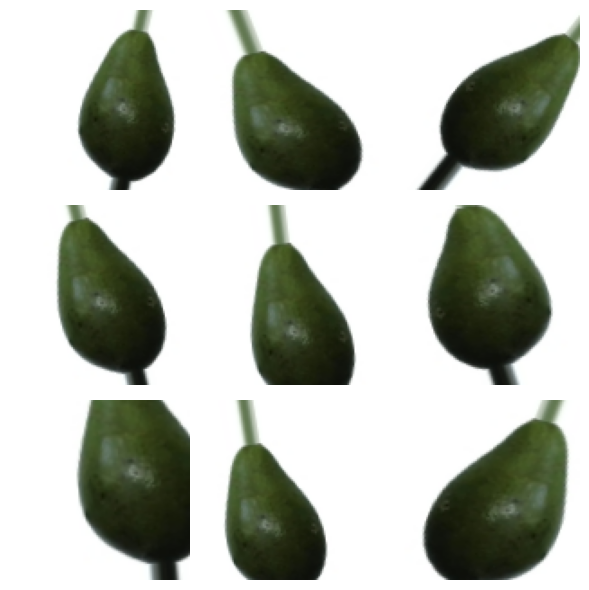

In [14]:
img_path = 'dataset/split/train/Avocado Green 1/r0_0_100.jpg'

img = load_img(img_path)
print(img.size)
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# Dengan rescale
preview_datagen = ImageDataGenerator(
    rescale=1./255,     # pixel jadi 0-1
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

aug_iter = preview_datagen.flow(x, batch_size=1)

fig, ax = plt.subplots(3, 3, figsize=(6,6))

for i in range(9):
    aug_img = next(aug_iter)[0]  # shape (100,100,3), float32 [0..1]
    # Konversi ke uint8 agar plt.imshow bisa tampil normal
    aug_img_uint8 = (aug_img * 255).astype(np.uint8)
    ax[i//3, i%3].imshow(aug_img_uint8)
    ax[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Simpan ukuran gambar unik yang ditemukan
sizes = set()

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            img = load_img(img_path)
            sizes.add(img.size)  # (width, height)

print("Ukuran gambar unik di training data:", sizes)

Ukuran gambar unik di training data: {(100, 100)}


### Data Preprocessing

In [16]:
IMAGE_SIZE = (100,100)
BATCH_SIZE = 32

In [17]:
# Training -> augmentasi + normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalisasi pixel ke 0-1
    rotation_range=40,       # rotasi acak max ±40°
    width_shift_range=0.2,   # geser horizontal max 20%
    height_shift_range=0.2,  # geser vertikal max 20%
    shear_range=0.2,         # shear transform
    zoom_range=0.2,          # zoom in/out
    horizontal_flip=True,    # flip horizontal
    fill_mode='nearest',     # isi piksel kosong,
)

# Validation -> hanya normalisasi
val_datagen = ImageDataGenerator(
    rescale= 1./255,
)

# Testing -> hanya normalisasi
test_datagen = ImageDataGenerator(
    rescale= 1./255,
)

In [18]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 97520 images belonging to 207 classes.
Found 20897 images belonging to 207 classes.
Found 20898 images belonging to 207 classes.


In [19]:
# Cek jumlah kelas
num_classes = len(train_generator.class_indices)
print(f'Jumlah kelas di data training: {num_classes}')

Jumlah kelas di data training: 207


## Modelling

In [20]:
# Bangun model CNN sederhana
model = Sequential([
    Input(shape=(100, 100, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Training model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 308s 99ms/step - accuracy: 0.4592 - loss: 2.1626 - val_accuracy: 0.8904 - val_loss: 0.3434
Epoch 2/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 320s 105ms/step - accuracy: 0.8791 - loss: 0.3523 - val_accuracy: 0.9607 - val_loss: 0.1044
Epoch 3/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 305s 100ms/step - accuracy: 0.9175 - loss: 0.2424 - val_accuracy: 0.9590 - val_loss: 0.1069
Epoch 4/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 316s 104ms/step - accuracy: 0.9336 - loss: 0.1931 - val_accuracy: 0.9711 - val_loss: 0.0823
Epoch 5/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 310s 102ms/step - accuracy: 0.9420 - loss: 0.1679 - val_accuracy: 0.9566 - val_loss: 0.1080
Epoch 6/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 305s 100ms/step - accuracy: 0.9489 - loss: 0.1481 - val_accuracy: 0.9606 - val_loss: 0.1089
Epoch 7/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 309s 101ms/step - accuracy: 0.9519 - loss: 0.1447 - val_accuracy: 0.9809 - val_loss: 0.0547
Epoch 8/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 319s 105ms/step - acc

In [24]:
# Simpan model
model.export("saved_model_cnn")

Saved artifact at 'saved_model_cnn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 207), dtype=tf.float32, name=None)
Captures:
  133908786525968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786527120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786525776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786524624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786526544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786527504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786524432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786527696: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Evaluasi dan Visualisasi

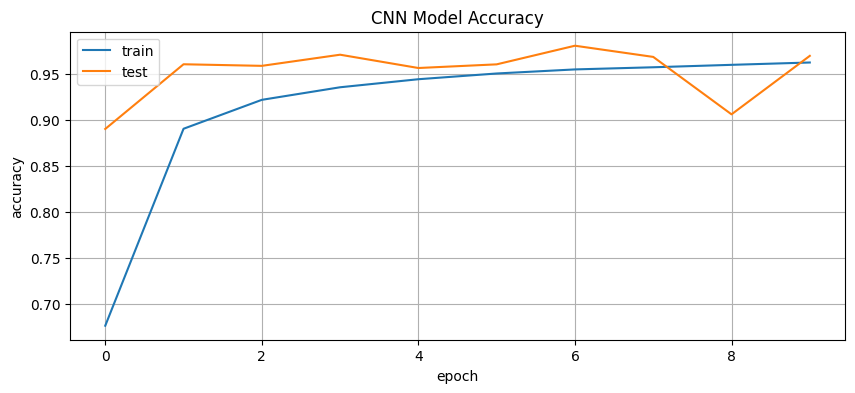

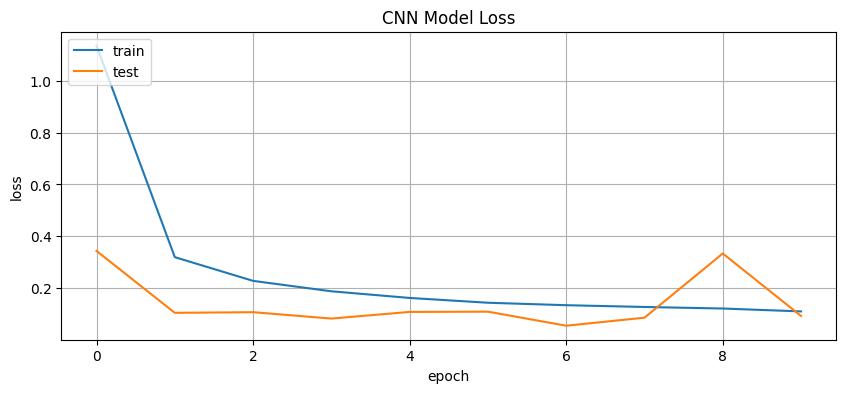

In [22]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [26]:
loss_train, accuracy_train = model.evaluate(train_generator)
print(f'Train Loss: {loss_train:.2f}')
print(f'Train Accuracy: {accuracy_train * 100:.2f}%')

3048/3048 ━━━━━━━━━━━━━━━━━━━━ 290s 95ms/step - accuracy: 0.9642 - loss: 0.1030
Train Loss: 0.10
Train Accuracy: 96.39%


In [25]:
loss_test, accuracy_test = model.evaluate(test_generator)
print(f'Test Loss: {loss_test:.2f}')
print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

  7/654 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9087 - loss: 0.3075

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


654/654 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9773 - loss: 0.0696
Test Loss: 0.06
Test Accuracy: 98.04%


In [27]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step
                           precision    recall  f1-score   support

                 Apple 10       0.98      0.91      0.94       140
                 Apple 11       1.00      1.00      1.00        85
                 Apple 12       1.00      0.78      0.88        93
                 Apple 13       1.00      1.00      1.00       140
                 Apple 14       1.00      1.00      1.00        93
                 Apple 17       0.88      1.00      0.93       122
                 Apple 18       1.00      0.82      0.90        96
                 Apple 19       1.00      1.00      1.00       146
                  Apple 5       1.00      1.00      1.00        88
                  Apple 6       0.98      1.00      0.99        94
                  Apple 7       1.00      1.00      1.00       139
                  Apple 8       0.91      0.98      0.94       137
                  Apple 9       0.99      1.00      1.00       139
         Apple Bra

## Konversi Model

In [28]:
# Convert model Keras ke TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan file TF-Lite
with open('model_cnn.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmphgkhcf_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 207), dtype=tf.float32, name=None)
Captures:
  133908786525968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786527120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786525776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786524624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786526544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786527504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786524432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133908786527696: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [33]:
# Simpan model Keras ke TFJS format di folder 'tfjs_model_dir'
tfjs.converters.save_keras_model(model, 'tfjs_model_cnn.bin')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [32]:
def predict_image(image_path, model, class_labels, image_size):
    # 1. Load gambar
    img = load_img(image_path, target_size=image_size)
    # 2. Ubah ke array
    img_array = img_to_array(img)
    # 3. Normalisasi
    img_array = img_array / 255.0
    # 4. Tambah dimensi batch
    img_array = np.expand_dims(img_array, axis=0)
    # 5. Predict
    pred = model.predict(img_array)
    # 6. Ambil indeks kelas tertinggi
    pred_class_idx = np.argmax(pred, axis=1)[0]
    # 7. Ambil label nama kelas
    pred_class_label = class_labels[pred_class_idx]

    return pred_class_label

# Contoh pemakaian:
class_labels = list(train_generator.class_indices.keys())
image_size = IMAGE_SIZE

img_path1 = 'dataset/split/test/Corn 1/111_100.jpg'
img_path2 = 'dataset/split/test/Chestnut 1/104_100.jpg'

print("Prediksi gambar 1:", predict_image(img_path1, model, class_labels, image_size))
print("Prediksi gambar 2:", predict_image(img_path2, model, class_labels, image_size))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediksi gambar 1: Corn 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediksi gambar 2: Chestnut 1
